## Variational Autoencoder
We will use 2-dim hidden vectors for approximation of parameters $\mu$, $\log\sigma^2$ of normal distribution. 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np
import os 

%matplotlib inline

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
root_folder = 'Conv_VAE_log_results'
fixed_folder = root_folder + '/Fixed_results'
AE_folder = root_folder + '/AE_results'

if os.path.isdir(root_folder):
    !rm -r $root_folder
os.mkdir(root_folder)
os.mkdir(fixed_folder)
os.mkdir(AE_folder)

In [4]:
mnist_tanh = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])

In [5]:
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_tanh)
fixed_data, _ = next(iter(test_loader))

In [6]:
class ConvLayer(nn.Module):
    def __init__(self, size, padding=1, pool_layer=nn.MaxPool2d(2, stride=2),
                 bn=False, dropout=False, activation_fn=nn.ReLU(), stride=1):
        super(ConvLayer, self).__init__()
        layers = []
        layers.append(nn.Conv2d(size[0], size[1], size[2], padding=padding, stride=stride))
        if pool_layer is not None:
            layers.append(pool_layer)
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [7]:
class DeconvLayer(nn.Module):
    def __init__(self, size, padding=1, stride=1, 
                 bn=False, dropout=False, activation_fn=nn.ReLU(), output_padding=0):
        super(DeconvLayer, self).__init__()
        layers = []
        layers.append(nn.ConvTranspose2d(size[0], size[1], size[2], padding=padding, 
                                         stride=stride, output_padding=output_padding))
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [8]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh):
        super(FullyConnected, self).__init__()
        layers = []
        
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout())
            layers.append(activation_fn())
        else: # нам не нужен дропаут и фнкция активации в последнем слое
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [9]:
class Net(nn.Module):
    def __init__(self, latent_size=32, gamma=1e-3, batchnorm=False, dropout=False, optim_type='SGD', **optim_params):
        super(Net, self).__init__()
    
        self.latent_size = latent_size
        self.gamma = gamma
        
        self._conv1 = ConvLayer([1, 16, 4], padding=0, bn=batchnorm, stride=2, pool_layer=None)
        self._conv2 = ConvLayer([16, 32, 4], padding=0, bn=batchnorm, stride=2, pool_layer=None)
        self._conv3 = ConvLayer([32, 32, 3], padding=0, bn=batchnorm, stride=2, pool_layer=None)
            
        self.fce = FullyConnected([32*2*2, latent_size*2])
        self.fcd = FullyConnected([latent_size, 32*2*2])
        
        self._deconv1 = DeconvLayer([32, 32, 3], stride=2, padding=0, bn=batchnorm)
        self._deconv2 = DeconvLayer([32, 16, 4], stride=2, padding=0, bn=batchnorm, output_padding=1)
        self._deconv3 = DeconvLayer([16, 1, 4], stride=2, padding=0, bn=batchnorm, activation_fn=nn.Tanh())
        
        self._loss = None
        if optim_type == 'SGD':
            self.optim = optim.SGD(self.parameters(), **optim_params)
        elif optim_type == 'Adadelta':
            self.optim = optim.Adadelta(self.parameters(), **optim_params)
        elif optim_type == 'RMSProp':
            self.optim = optim.RMSprop(self.parameters(), **optim_params)
        elif optim_type == 'Adam':
            self.optim = optim.Adam(self.parameters(), **optim_params)
        
    def conv(self, x):
        l1 = self._conv1(x)
        l2 = self._conv2(l1)
        l3 = self._conv3(l2)
        return l3, l2, l1
    
    def encode(self, x):
        l3 = self.conv(x)[0]
        flatten = l3.view(-1, 32*2*2)
        h = self.fce(flatten)
        self.mu, self.logvar = h.split(self.latent_size, dim=1)
        return self.mu, self.logvar
    
    def decode(self, h):
        flatten = self.fcd(h)
        l1 = flatten.view(-1, 32, 2, 2)
        l2 = self._deconv1(l1)
        l3 = self._deconv2(l2)
        x = self._deconv3(l3)
        return x
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        if self.training:
            std = logvar.mul(0.5).exp()
            h = self._sample(mu.shape[0]) * std + mu
        else:
            h = mu
        x = self.decode(h)
        return x
    
    def _sample(self, n):
        return torch.randn([n, self.latent_size])
    
    def loss(self, output, target, size_average=True):
        KLD = self.mu**2 + self.logvar.exp() - 1 - self.logvar
        KLD = 0.5*KLD.sum(1)
        if size_average:
            self.KLD = KLD.mean()
        else:
            self.KLD = KLD.sum()
        self._loss = F.mse_loss(output, target, size_average=size_average)
        
        return self._loss + self.gamma*self.KLD

In [61]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, data)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.4f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.4f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss,))
        print(line + losses)

In [62]:
def test(models, loader, epoch, log=None):
    test_size = len(loader)
    test_reconstruction_loss = {k: 0. for k in models}
    test_KL_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                m.loss(output[k], data)
                test_reconstruction_loss[k] += m._loss.item()
                test_KL_loss[k] += m.KLD.item()
    
    for k in models:
        test_reconstruction_loss[k] /= test_size
        test_KL_loss[k] /= test_size
    report = 'Test losses: ' + ' '.join(['{}: {:.4f}/{:.4f}'.format(k, 
                                                                    test_reconstruction_loss[k], 
                                                                    test_KL_loss[k]) for k in models])
    for k in models:
        if log is not None:
            log[k].append((test_reconstruction_loss[k], test_KL_loss[k]))
        with torch.no_grad():
            ae_data = models[k](fixed_data).data.numpy()
            fixed_gen = models[k].decode(fixed_z).data.numpy()
            plot_mnist(ae_data, (5, 10), True, AE_folder + '/%s_%03d.png' % (k, epoch))
            plot_mnist(fixed_gen, (5, 10), True, fixed_folder + '/%s_%03d.png' % (k, epoch))
    print(report)

Set latent size is equal to 2

In [46]:
latent_size = 2
fixed_z = torch.randn((50, latent_size))
fixed_z.shape

torch.Size([50, 2])

In [47]:
# z ~ N(0, 1)
fixed_z[0]

tensor([ 0.9026, -0.2964])

In [72]:
models = {'VAE2': Net(latent_size=latent_size, gamma=0.001, batchnorm=True, dropout=True, optim_type='Adam', lr=0.5e-3)}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

Train Epoch: 1 [0/50000 (0%)]	Losses VAE2: 0.9264
Train Epoch: 1 [10000/50000 (20%)]	Losses VAE2: 0.6864
Train Epoch: 1 [20000/50000 (40%)]	Losses VAE2: 0.5448
Train Epoch: 1 [30000/50000 (60%)]	Losses VAE2: 0.4682
Train Epoch: 1 [40000/50000 (80%)]	Losses VAE2: 0.3861
Train Epoch: 1 [50000/50000 (100%)]	Losses VAE2: 0.3352


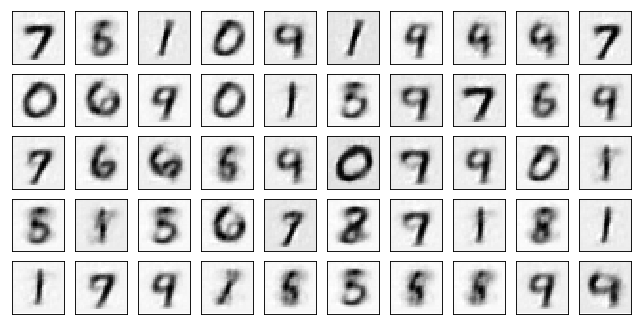

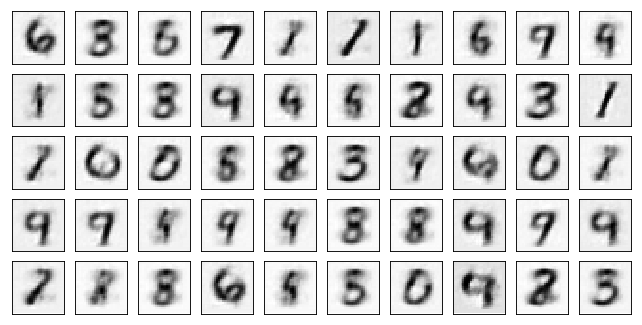

Test losses: VAE2: 0.3340/5.1886
Train Epoch: 2 [0/50000 (0%)]	Losses VAE2: 0.3390
Train Epoch: 2 [10000/50000 (20%)]	Losses VAE2: 0.3046
Train Epoch: 2 [20000/50000 (40%)]	Losses VAE2: 0.2776
Train Epoch: 2 [30000/50000 (60%)]	Losses VAE2: 0.2631
Train Epoch: 2 [40000/50000 (80%)]	Losses VAE2: 0.2248
Train Epoch: 2 [50000/50000 (100%)]	Losses VAE2: 0.2170


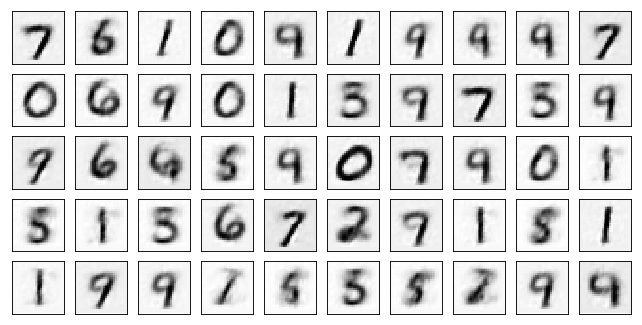

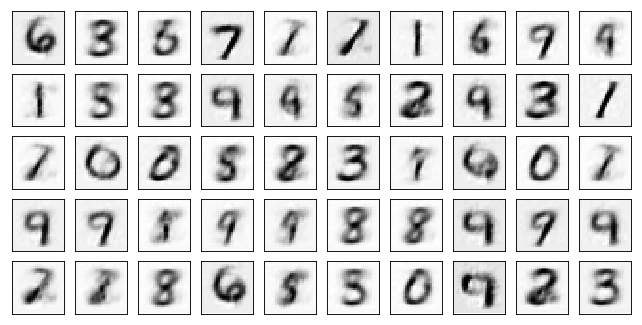

Test losses: VAE2: 0.2261/5.8665
Train Epoch: 3 [0/50000 (0%)]	Losses VAE2: 0.2238
Train Epoch: 3 [10000/50000 (20%)]	Losses VAE2: 0.2244
Train Epoch: 3 [20000/50000 (40%)]	Losses VAE2: 0.2034
Train Epoch: 3 [30000/50000 (60%)]	Losses VAE2: 0.2056
Train Epoch: 3 [40000/50000 (80%)]	Losses VAE2: 0.2006
Train Epoch: 3 [50000/50000 (100%)]	Losses VAE2: 0.1970


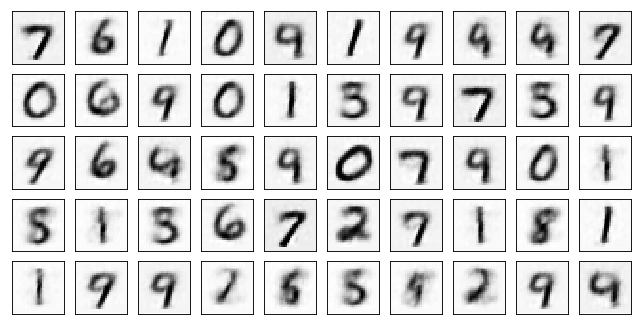

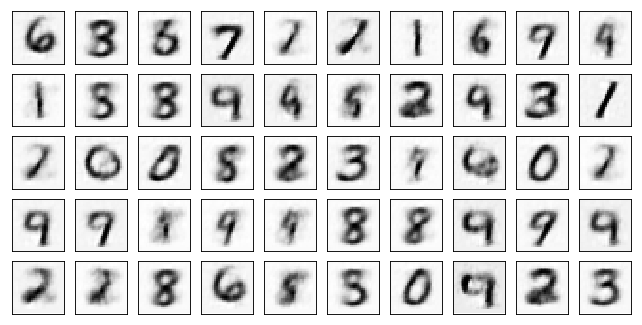

Test losses: VAE2: 0.1954/6.1447
Train Epoch: 4 [0/50000 (0%)]	Losses VAE2: 0.1866
Train Epoch: 4 [10000/50000 (20%)]	Losses VAE2: 0.1970
Train Epoch: 4 [20000/50000 (40%)]	Losses VAE2: 0.2018
Train Epoch: 4 [30000/50000 (60%)]	Losses VAE2: 0.1888
Train Epoch: 4 [40000/50000 (80%)]	Losses VAE2: 0.2070
Train Epoch: 4 [50000/50000 (100%)]	Losses VAE2: 0.1910


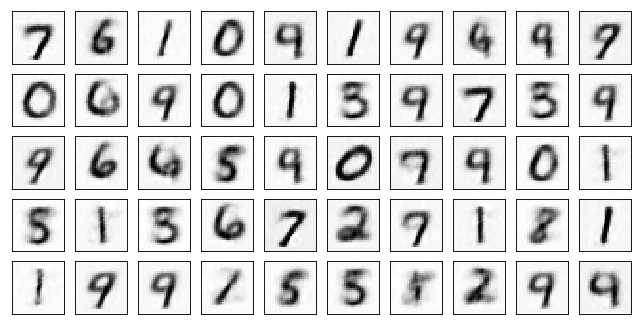

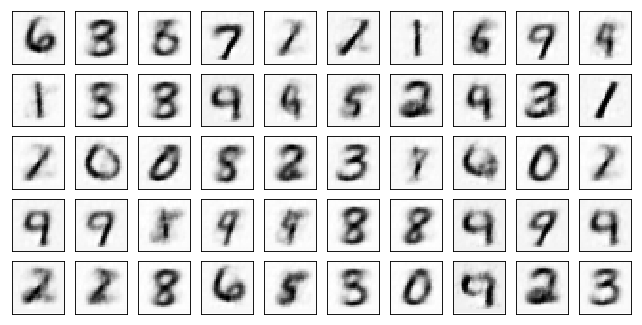

Test losses: VAE2: 0.1810/6.2513
Train Epoch: 5 [0/50000 (0%)]	Losses VAE2: 0.1833
Train Epoch: 5 [10000/50000 (20%)]	Losses VAE2: 0.1783
Train Epoch: 5 [20000/50000 (40%)]	Losses VAE2: 0.1730
Train Epoch: 5 [30000/50000 (60%)]	Losses VAE2: 0.1698
Train Epoch: 5 [40000/50000 (80%)]	Losses VAE2: 0.1721
Train Epoch: 5 [50000/50000 (100%)]	Losses VAE2: 0.1495


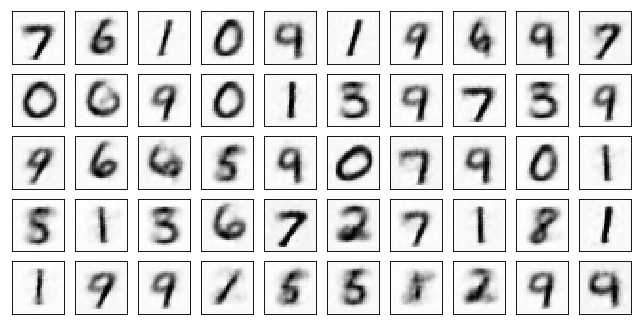

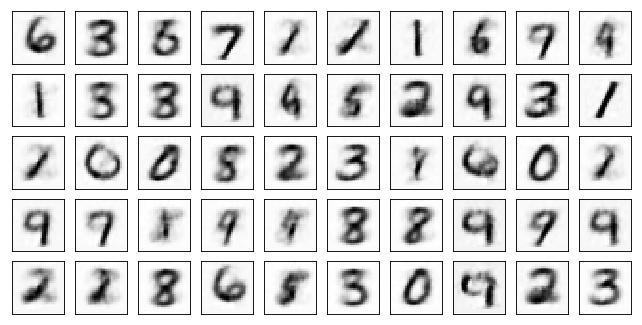

Test losses: VAE2: 0.1738/6.2943
Train Epoch: 6 [0/50000 (0%)]	Losses VAE2: 0.1715
Train Epoch: 6 [10000/50000 (20%)]	Losses VAE2: 0.1931
Train Epoch: 6 [20000/50000 (40%)]	Losses VAE2: 0.1680
Train Epoch: 6 [30000/50000 (60%)]	Losses VAE2: 0.1631
Train Epoch: 6 [40000/50000 (80%)]	Losses VAE2: 0.1801
Train Epoch: 6 [50000/50000 (100%)]	Losses VAE2: 0.1795


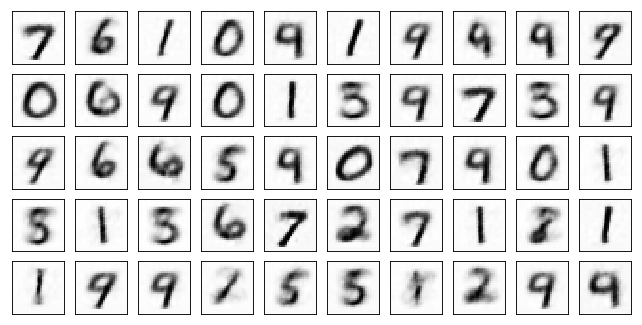

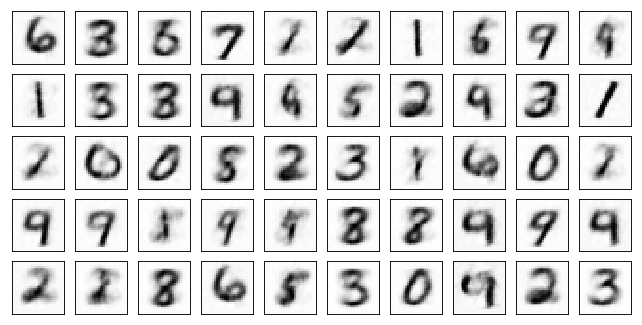

Test losses: VAE2: 0.1696/6.5377
Train Epoch: 7 [0/50000 (0%)]	Losses VAE2: 0.1537
Train Epoch: 7 [10000/50000 (20%)]	Losses VAE2: 0.1578
Train Epoch: 7 [20000/50000 (40%)]	Losses VAE2: 0.1779
Train Epoch: 7 [30000/50000 (60%)]	Losses VAE2: 0.1727
Train Epoch: 7 [40000/50000 (80%)]	Losses VAE2: 0.1753
Train Epoch: 7 [50000/50000 (100%)]	Losses VAE2: 0.1742


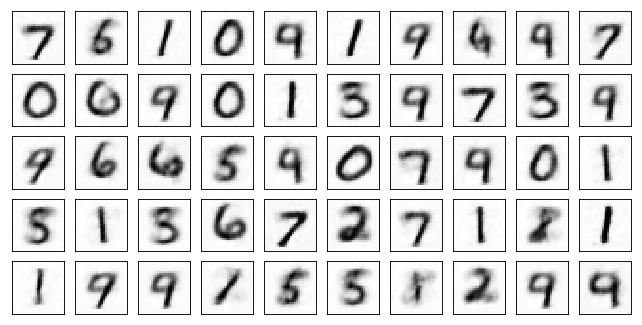

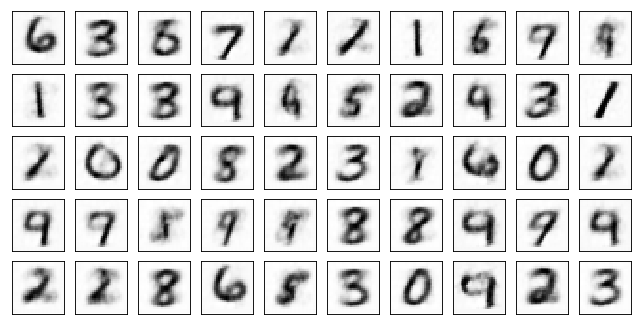

Test losses: VAE2: 0.1668/6.7372
Train Epoch: 8 [0/50000 (0%)]	Losses VAE2: 0.1659
Train Epoch: 8 [10000/50000 (20%)]	Losses VAE2: 0.1671
Train Epoch: 8 [20000/50000 (40%)]	Losses VAE2: 0.1907
Train Epoch: 8 [30000/50000 (60%)]	Losses VAE2: 0.1668
Train Epoch: 8 [40000/50000 (80%)]	Losses VAE2: 0.1803
Train Epoch: 8 [50000/50000 (100%)]	Losses VAE2: 0.1847


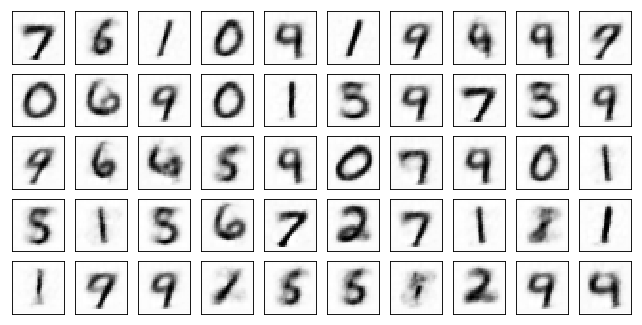

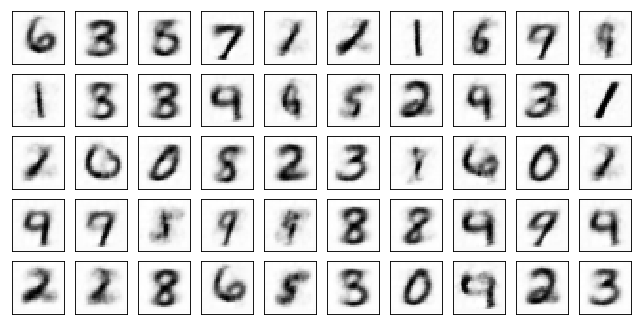

Test losses: VAE2: 0.1652/6.5647
Train Epoch: 9 [0/50000 (0%)]	Losses VAE2: 0.1668
Train Epoch: 9 [10000/50000 (20%)]	Losses VAE2: 0.1616
Train Epoch: 9 [20000/50000 (40%)]	Losses VAE2: 0.1674
Train Epoch: 9 [30000/50000 (60%)]	Losses VAE2: 0.1645
Train Epoch: 9 [40000/50000 (80%)]	Losses VAE2: 0.1687
Train Epoch: 9 [50000/50000 (100%)]	Losses VAE2: 0.1745


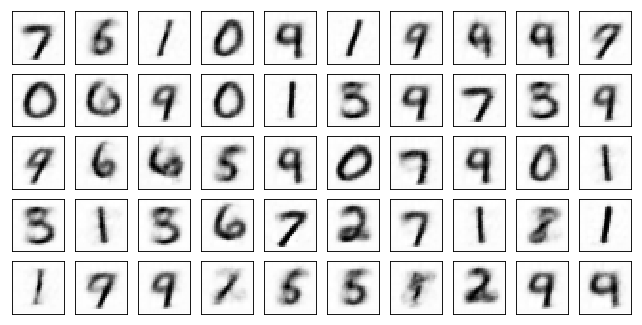

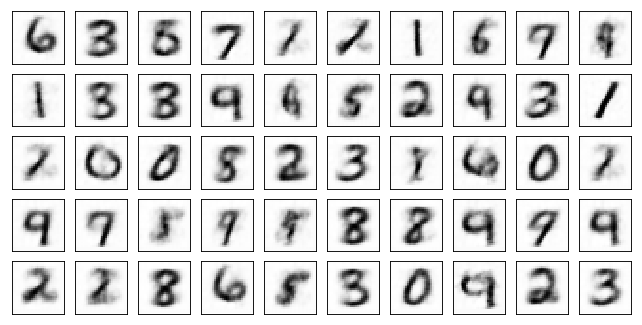

Test losses: VAE2: 0.1645/6.5709
Train Epoch: 10 [0/50000 (0%)]	Losses VAE2: 0.1643
Train Epoch: 10 [10000/50000 (20%)]	Losses VAE2: 0.1811
Train Epoch: 10 [20000/50000 (40%)]	Losses VAE2: 0.1483
Train Epoch: 10 [30000/50000 (60%)]	Losses VAE2: 0.1620
Train Epoch: 10 [40000/50000 (80%)]	Losses VAE2: 0.1447
Train Epoch: 10 [50000/50000 (100%)]	Losses VAE2: 0.1668


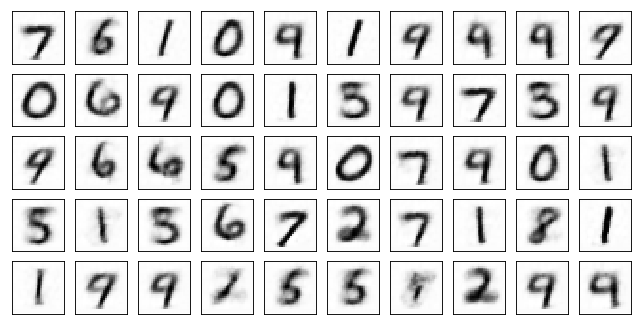

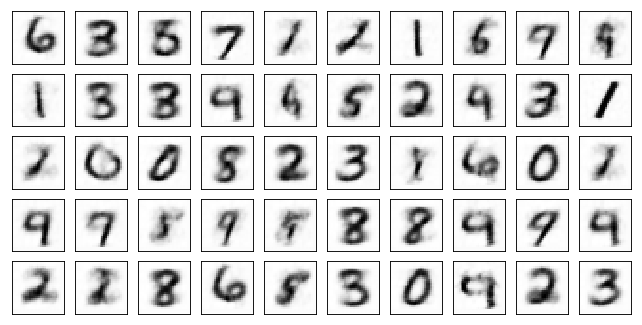

Test losses: VAE2: 0.1630/6.6178
Train Epoch: 11 [0/50000 (0%)]	Losses VAE2: 0.1550
Train Epoch: 11 [10000/50000 (20%)]	Losses VAE2: 0.1818
Train Epoch: 11 [20000/50000 (40%)]	Losses VAE2: 0.1602
Train Epoch: 11 [30000/50000 (60%)]	Losses VAE2: 0.1661
Train Epoch: 11 [40000/50000 (80%)]	Losses VAE2: 0.1551
Train Epoch: 11 [50000/50000 (100%)]	Losses VAE2: 0.1795


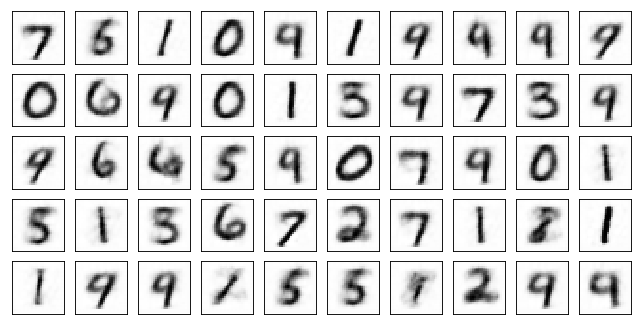

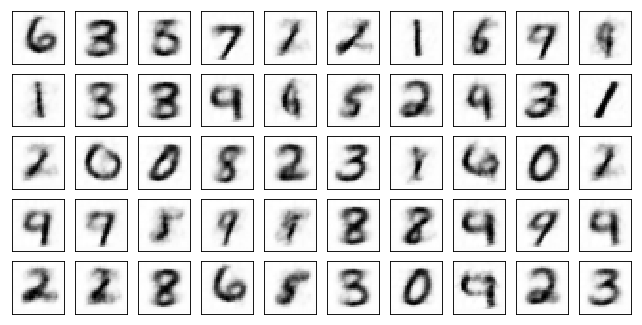

Test losses: VAE2: 0.1617/6.6792
Train Epoch: 12 [0/50000 (0%)]	Losses VAE2: 0.1514
Train Epoch: 12 [10000/50000 (20%)]	Losses VAE2: 0.1528
Train Epoch: 12 [20000/50000 (40%)]	Losses VAE2: 0.1740
Train Epoch: 12 [30000/50000 (60%)]	Losses VAE2: 0.1513
Train Epoch: 12 [40000/50000 (80%)]	Losses VAE2: 0.1672
Train Epoch: 12 [50000/50000 (100%)]	Losses VAE2: 0.1780


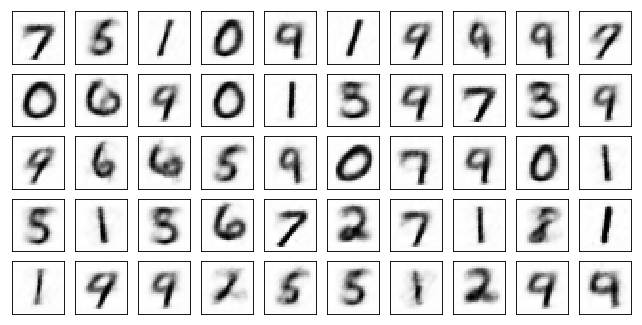

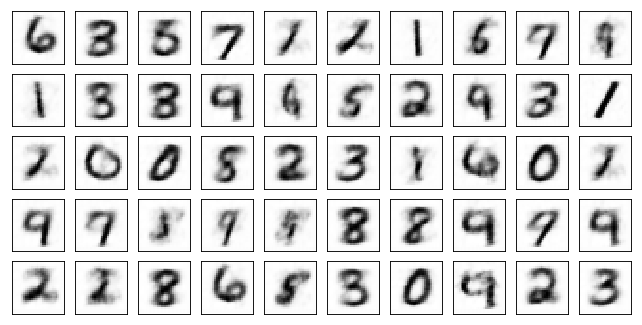

Test losses: VAE2: 0.1613/6.7836
Train Epoch: 13 [0/50000 (0%)]	Losses VAE2: 0.1579
Train Epoch: 13 [10000/50000 (20%)]	Losses VAE2: 0.1626
Train Epoch: 13 [20000/50000 (40%)]	Losses VAE2: 0.1709
Train Epoch: 13 [30000/50000 (60%)]	Losses VAE2: 0.1680
Train Epoch: 13 [40000/50000 (80%)]	Losses VAE2: 0.1568
Train Epoch: 13 [50000/50000 (100%)]	Losses VAE2: 0.1543


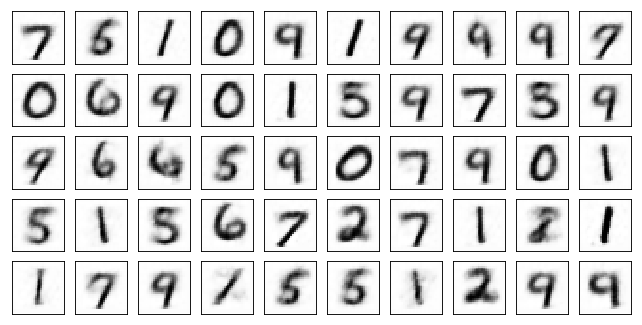

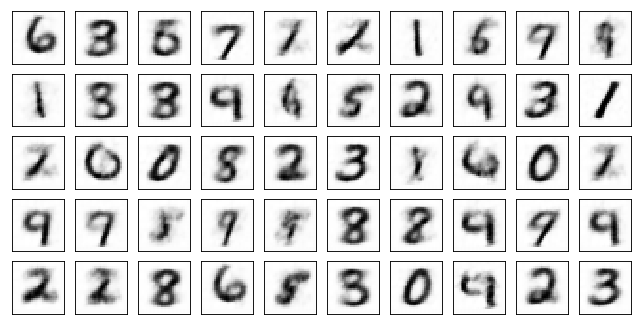

Test losses: VAE2: 0.1610/6.9458
Train Epoch: 14 [0/50000 (0%)]	Losses VAE2: 0.1698
Train Epoch: 14 [10000/50000 (20%)]	Losses VAE2: 0.1846
Train Epoch: 14 [20000/50000 (40%)]	Losses VAE2: 0.1520
Train Epoch: 14 [30000/50000 (60%)]	Losses VAE2: 0.1692
Train Epoch: 14 [40000/50000 (80%)]	Losses VAE2: 0.1452
Train Epoch: 14 [50000/50000 (100%)]	Losses VAE2: 0.1491


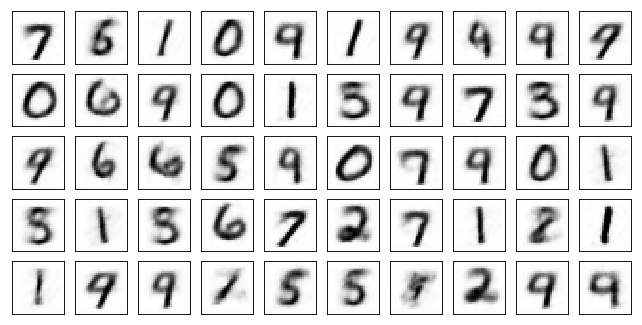

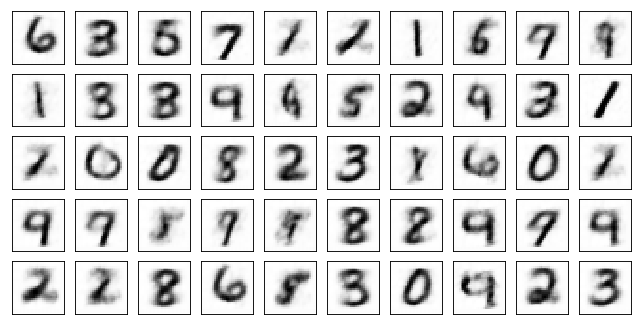

Test losses: VAE2: 0.1611/6.6809
Train Epoch: 15 [0/50000 (0%)]	Losses VAE2: 0.1601
Train Epoch: 15 [10000/50000 (20%)]	Losses VAE2: 0.1524
Train Epoch: 15 [20000/50000 (40%)]	Losses VAE2: 0.1646
Train Epoch: 15 [30000/50000 (60%)]	Losses VAE2: 0.1462
Train Epoch: 15 [40000/50000 (80%)]	Losses VAE2: 0.1667
Train Epoch: 15 [50000/50000 (100%)]	Losses VAE2: 0.1636


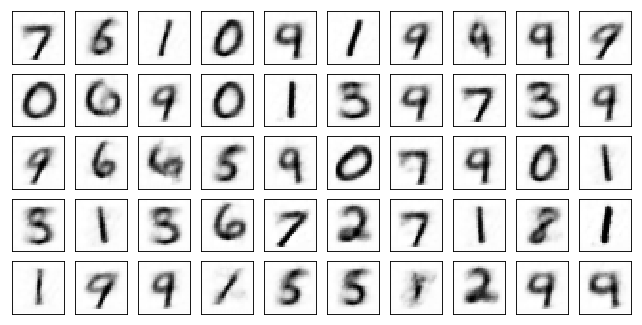

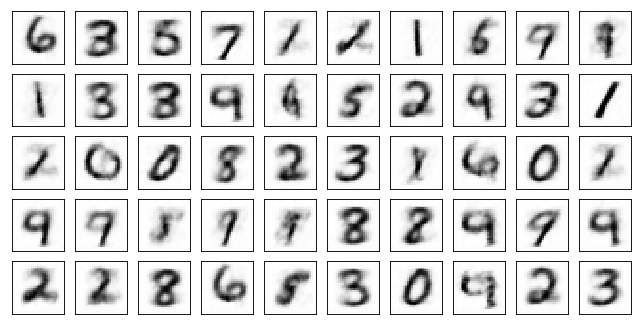

Test losses: VAE2: 0.1603/6.8707
Train Epoch: 16 [0/50000 (0%)]	Losses VAE2: 0.1509
Train Epoch: 16 [10000/50000 (20%)]	Losses VAE2: 0.1587
Train Epoch: 16 [20000/50000 (40%)]	Losses VAE2: 0.1532
Train Epoch: 16 [30000/50000 (60%)]	Losses VAE2: 0.1603
Train Epoch: 16 [40000/50000 (80%)]	Losses VAE2: 0.1578
Train Epoch: 16 [50000/50000 (100%)]	Losses VAE2: 0.1555


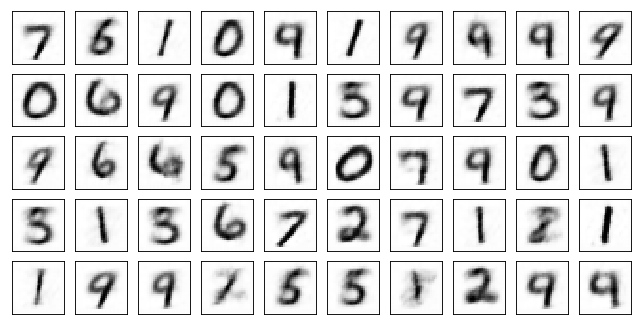

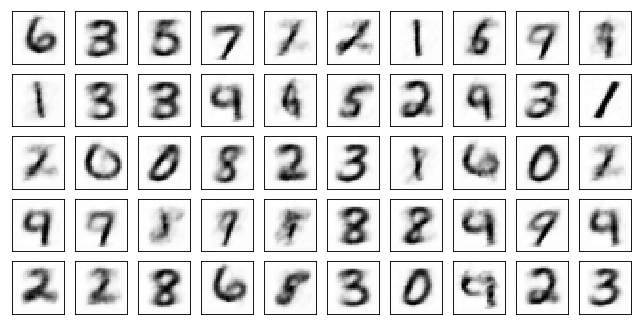

Test losses: VAE2: 0.1600/6.8415
Train Epoch: 17 [0/50000 (0%)]	Losses VAE2: 0.1621
Train Epoch: 17 [10000/50000 (20%)]	Losses VAE2: 0.1428
Train Epoch: 17 [20000/50000 (40%)]	Losses VAE2: 0.1622
Train Epoch: 17 [30000/50000 (60%)]	Losses VAE2: 0.1536
Train Epoch: 17 [40000/50000 (80%)]	Losses VAE2: 0.1572
Train Epoch: 17 [50000/50000 (100%)]	Losses VAE2: 0.1539


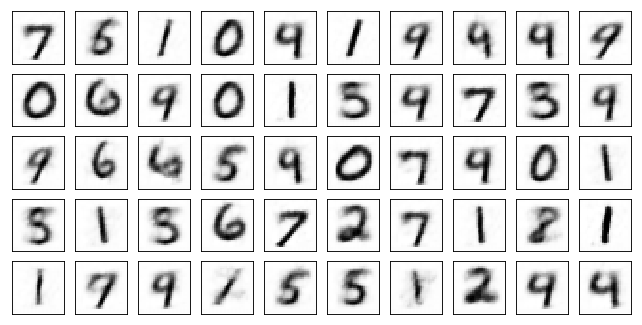

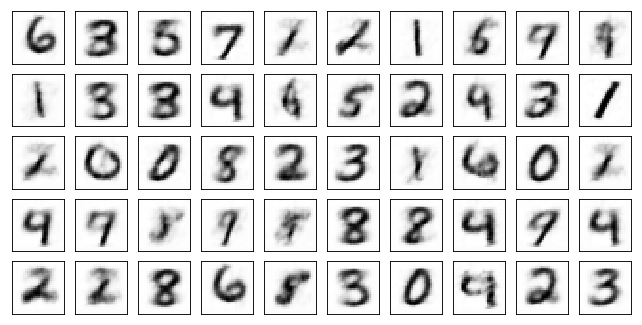

Test losses: VAE2: 0.1594/6.7981
Train Epoch: 18 [0/50000 (0%)]	Losses VAE2: 0.1495
Train Epoch: 18 [10000/50000 (20%)]	Losses VAE2: 0.1446
Train Epoch: 18 [20000/50000 (40%)]	Losses VAE2: 0.1533
Train Epoch: 18 [30000/50000 (60%)]	Losses VAE2: 0.1578
Train Epoch: 18 [40000/50000 (80%)]	Losses VAE2: 0.1599
Train Epoch: 18 [50000/50000 (100%)]	Losses VAE2: 0.1501


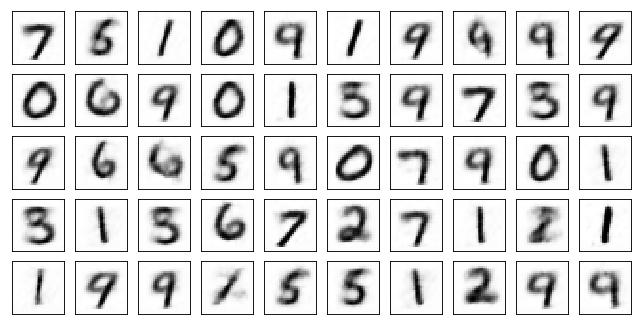

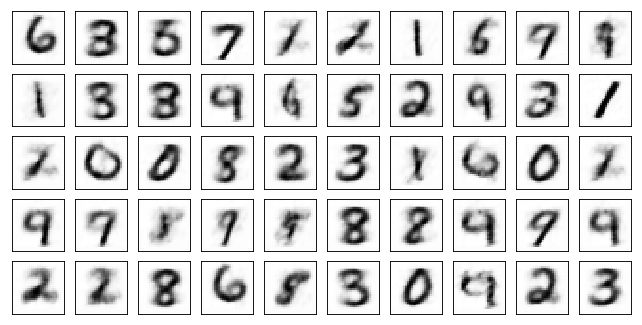

Test losses: VAE2: 0.1588/6.7961
Train Epoch: 19 [0/50000 (0%)]	Losses VAE2: 0.1520
Train Epoch: 19 [10000/50000 (20%)]	Losses VAE2: 0.1642
Train Epoch: 19 [20000/50000 (40%)]	Losses VAE2: 0.1754
Train Epoch: 19 [30000/50000 (60%)]	Losses VAE2: 0.1417
Train Epoch: 19 [40000/50000 (80%)]	Losses VAE2: 0.1749
Train Epoch: 19 [50000/50000 (100%)]	Losses VAE2: 0.1529


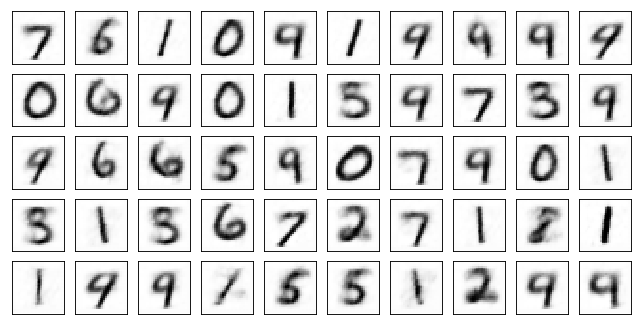

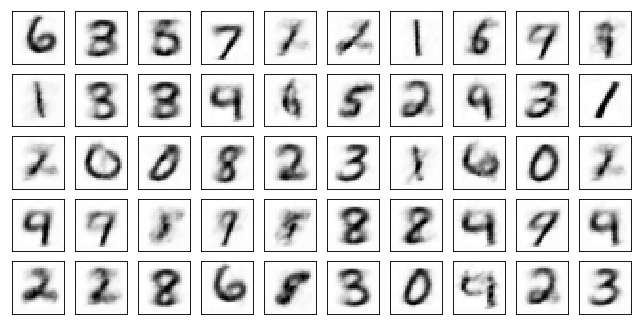

Test losses: VAE2: 0.1601/6.9247
Train Epoch: 20 [0/50000 (0%)]	Losses VAE2: 0.1603
Train Epoch: 20 [10000/50000 (20%)]	Losses VAE2: 0.1432
Train Epoch: 20 [20000/50000 (40%)]	Losses VAE2: 0.1649
Train Epoch: 20 [30000/50000 (60%)]	Losses VAE2: 0.1354
Train Epoch: 20 [40000/50000 (80%)]	Losses VAE2: 0.1672
Train Epoch: 20 [50000/50000 (100%)]	Losses VAE2: 0.1609


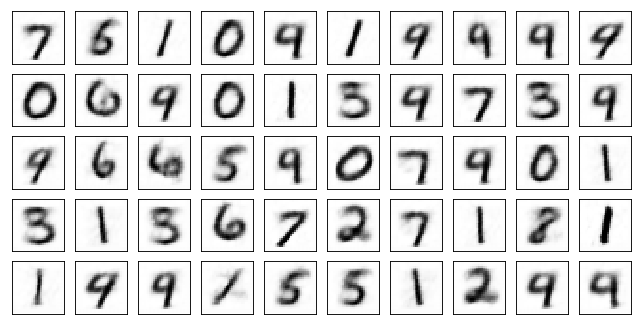

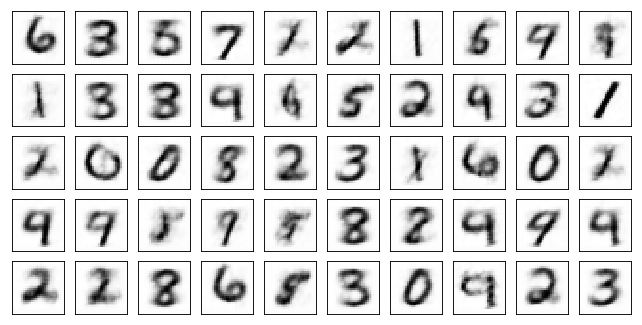

Test losses: VAE2: 0.1583/6.9252
Train Epoch: 21 [0/50000 (0%)]	Losses VAE2: 0.1521
Train Epoch: 21 [10000/50000 (20%)]	Losses VAE2: 0.1443
Train Epoch: 21 [20000/50000 (40%)]	Losses VAE2: 0.1560
Train Epoch: 21 [30000/50000 (60%)]	Losses VAE2: 0.1423
Train Epoch: 21 [40000/50000 (80%)]	Losses VAE2: 0.1595
Train Epoch: 21 [50000/50000 (100%)]	Losses VAE2: 0.1470


Exception ignored in: <bound method Image.__del__ of <PIL.Image.Image image mode= size=0x0 at 0x7F16974C7160>>
Traceback (most recent call last):
  File "/home/evgeny/.local/lib/python3.6/site-packages/PIL/Image.py", line 588, in __del__
    def __del__(self):
KeyboardInterrupt


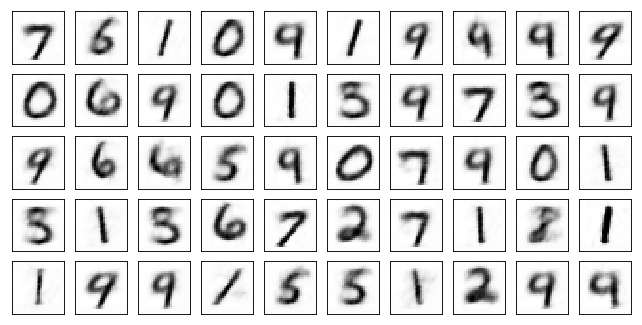

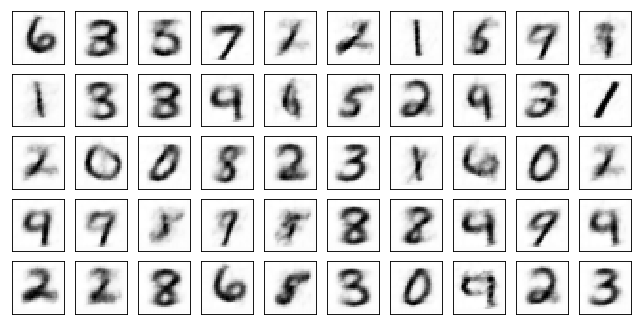

Test losses: VAE2: 0.1580/7.0273
Train Epoch: 22 [0/50000 (0%)]	Losses VAE2: 0.1683
Train Epoch: 22 [10000/50000 (20%)]	Losses VAE2: 0.1428
Train Epoch: 22 [20000/50000 (40%)]	Losses VAE2: 0.1491
Train Epoch: 22 [30000/50000 (60%)]	Losses VAE2: 0.1424
Train Epoch: 22 [40000/50000 (80%)]	Losses VAE2: 0.1622
Train Epoch: 22 [50000/50000 (100%)]	Losses VAE2: 0.1693


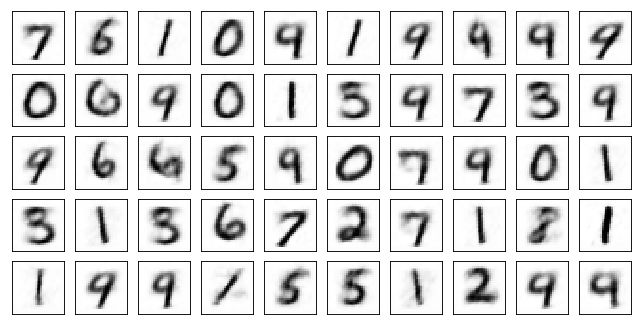

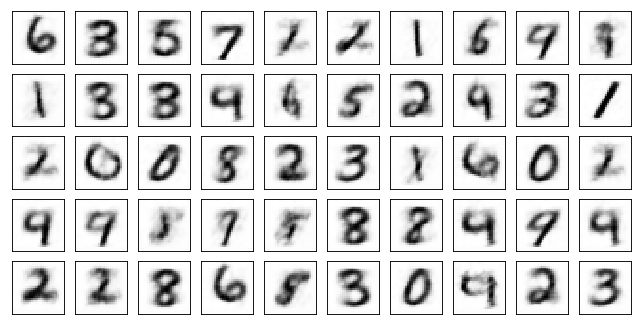

Test losses: VAE2: 0.1576/7.0317
Train Epoch: 23 [0/50000 (0%)]	Losses VAE2: 0.1583
Train Epoch: 23 [10000/50000 (20%)]	Losses VAE2: 0.1644
Train Epoch: 23 [20000/50000 (40%)]	Losses VAE2: 0.1496
Train Epoch: 23 [30000/50000 (60%)]	Losses VAE2: 0.1545
Train Epoch: 23 [40000/50000 (80%)]	Losses VAE2: 0.1648
Train Epoch: 23 [50000/50000 (100%)]	Losses VAE2: 0.1470


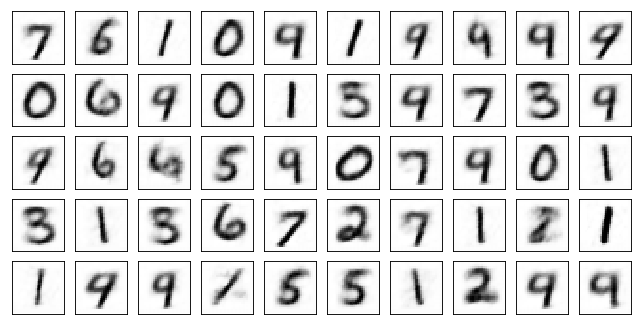

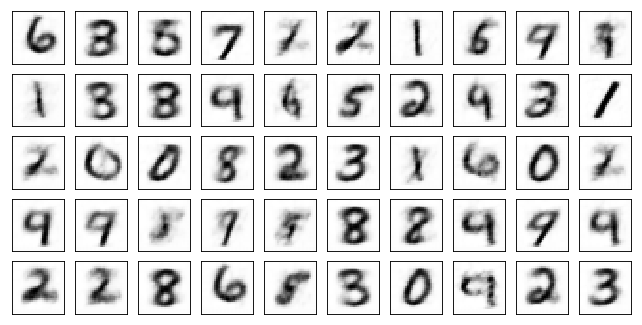

Test losses: VAE2: 0.1574/6.9316
Train Epoch: 24 [0/50000 (0%)]	Losses VAE2: 0.1392
Train Epoch: 24 [10000/50000 (20%)]	Losses VAE2: 0.1579
Train Epoch: 24 [20000/50000 (40%)]	Losses VAE2: 0.1631
Train Epoch: 24 [30000/50000 (60%)]	Losses VAE2: 0.1677
Train Epoch: 24 [40000/50000 (80%)]	Losses VAE2: 0.1459
Train Epoch: 24 [50000/50000 (100%)]	Losses VAE2: 0.1716


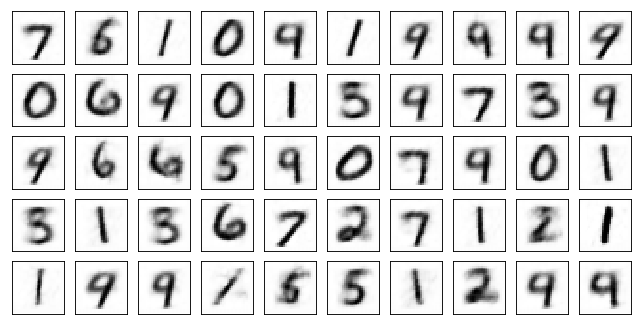

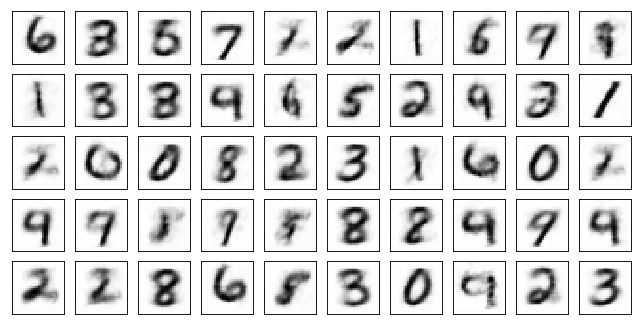

Test losses: VAE2: 0.1572/6.9655
Train Epoch: 25 [0/50000 (0%)]	Losses VAE2: 0.1607
Train Epoch: 25 [10000/50000 (20%)]	Losses VAE2: 0.1521
Train Epoch: 25 [20000/50000 (40%)]	Losses VAE2: 0.1656
Train Epoch: 25 [30000/50000 (60%)]	Losses VAE2: 0.1581
Train Epoch: 25 [40000/50000 (80%)]	Losses VAE2: 0.1543
Train Epoch: 25 [50000/50000 (100%)]	Losses VAE2: 0.1623


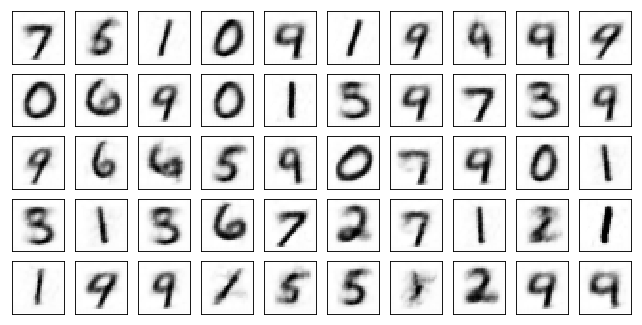

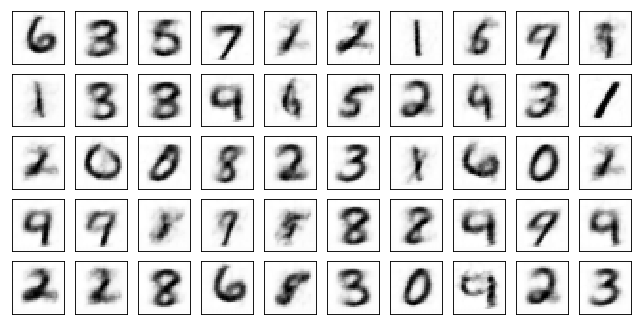

Test losses: VAE2: 0.1570/6.9009
Train Epoch: 26 [0/50000 (0%)]	Losses VAE2: 0.1427
Train Epoch: 26 [10000/50000 (20%)]	Losses VAE2: 0.1514
Train Epoch: 26 [20000/50000 (40%)]	Losses VAE2: 0.1455
Train Epoch: 26 [30000/50000 (60%)]	Losses VAE2: 0.1592
Train Epoch: 26 [40000/50000 (80%)]	Losses VAE2: 0.1487
Train Epoch: 26 [50000/50000 (100%)]	Losses VAE2: 0.1505


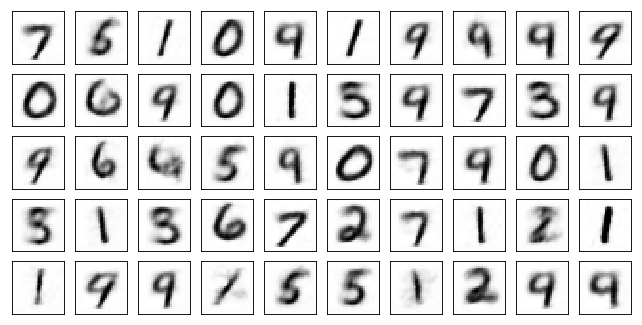

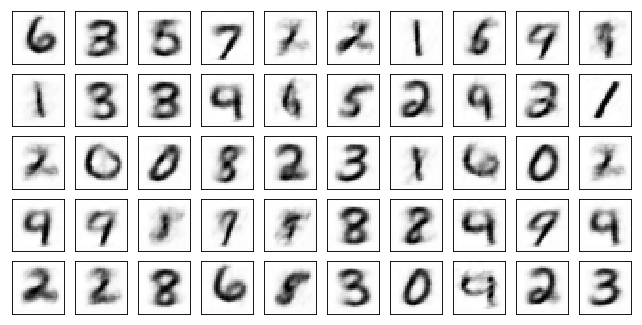

Test losses: VAE2: 0.1568/6.8968
Train Epoch: 27 [0/50000 (0%)]	Losses VAE2: 0.1499
Train Epoch: 27 [10000/50000 (20%)]	Losses VAE2: 0.1573
Train Epoch: 27 [20000/50000 (40%)]	Losses VAE2: 0.1627
Train Epoch: 27 [30000/50000 (60%)]	Losses VAE2: 0.1430
Train Epoch: 27 [40000/50000 (80%)]	Losses VAE2: 0.1609
Train Epoch: 27 [50000/50000 (100%)]	Losses VAE2: 0.1535


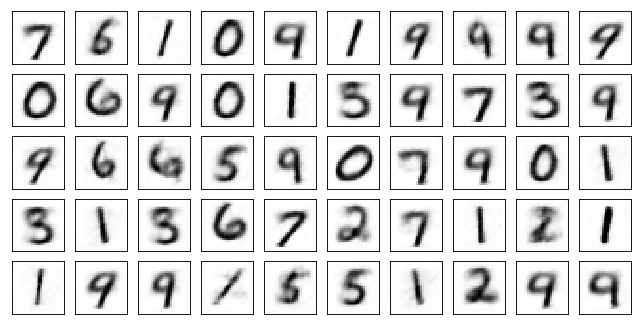

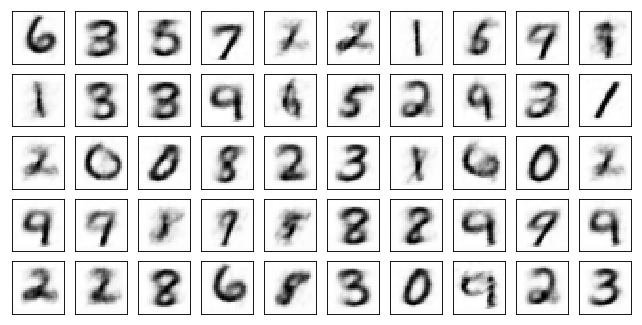

Test losses: VAE2: 0.1563/6.9679
Train Epoch: 28 [0/50000 (0%)]	Losses VAE2: 0.1422
Train Epoch: 28 [10000/50000 (20%)]	Losses VAE2: 0.1528
Train Epoch: 28 [20000/50000 (40%)]	Losses VAE2: 0.1450
Train Epoch: 28 [30000/50000 (60%)]	Losses VAE2: 0.1493
Train Epoch: 28 [40000/50000 (80%)]	Losses VAE2: 0.1478
Train Epoch: 28 [50000/50000 (100%)]	Losses VAE2: 0.1808


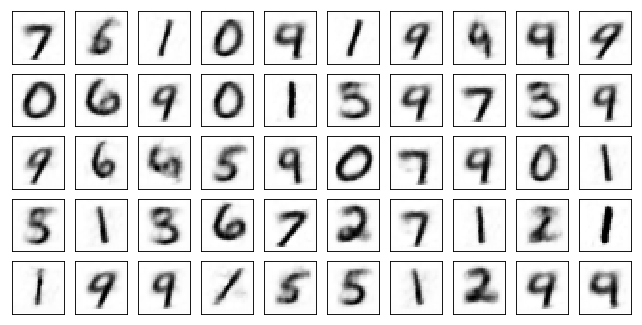

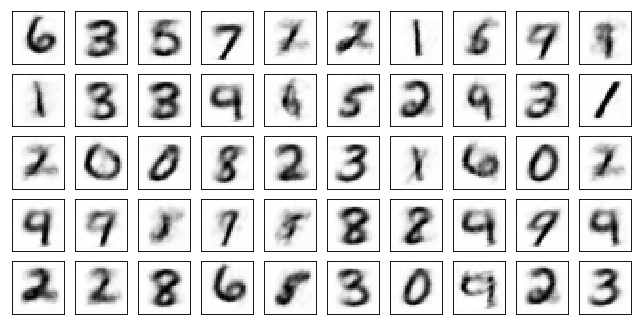

Test losses: VAE2: 0.1562/7.0429
Train Epoch: 29 [0/50000 (0%)]	Losses VAE2: 0.1598
Train Epoch: 29 [10000/50000 (20%)]	Losses VAE2: 0.1609
Train Epoch: 29 [20000/50000 (40%)]	Losses VAE2: 0.1592
Train Epoch: 29 [30000/50000 (60%)]	Losses VAE2: 0.1483
Train Epoch: 29 [40000/50000 (80%)]	Losses VAE2: 0.1459
Train Epoch: 29 [50000/50000 (100%)]	Losses VAE2: 0.1539


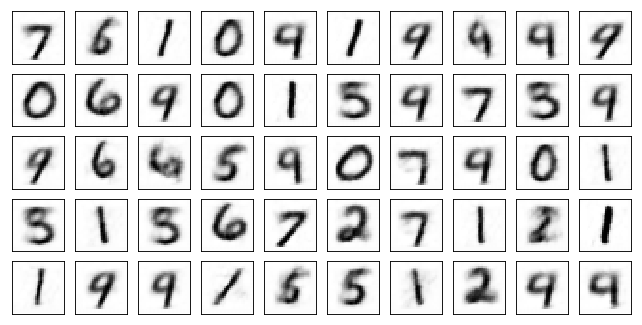

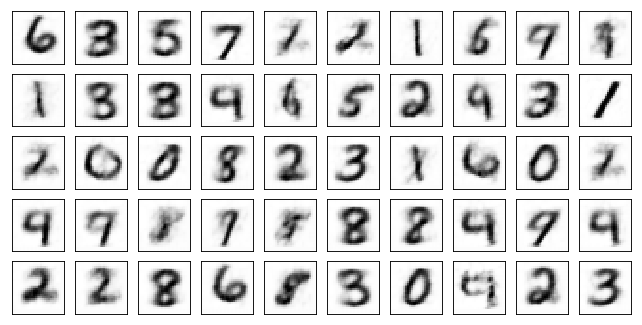

Test losses: VAE2: 0.1564/7.0916
Train Epoch: 30 [0/50000 (0%)]	Losses VAE2: 0.1418
Train Epoch: 30 [10000/50000 (20%)]	Losses VAE2: 0.1677
Train Epoch: 30 [20000/50000 (40%)]	Losses VAE2: 0.1587
Train Epoch: 30 [30000/50000 (60%)]	Losses VAE2: 0.1475
Train Epoch: 30 [40000/50000 (80%)]	Losses VAE2: 0.1471
Train Epoch: 30 [50000/50000 (100%)]	Losses VAE2: 0.1448


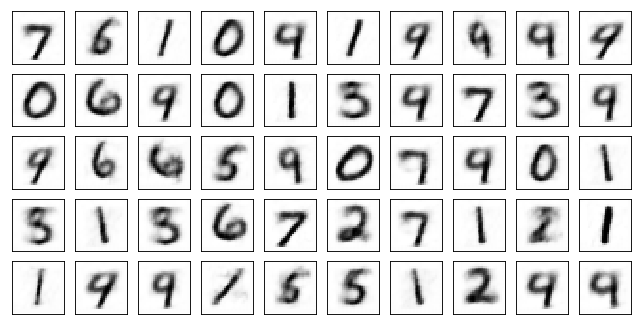

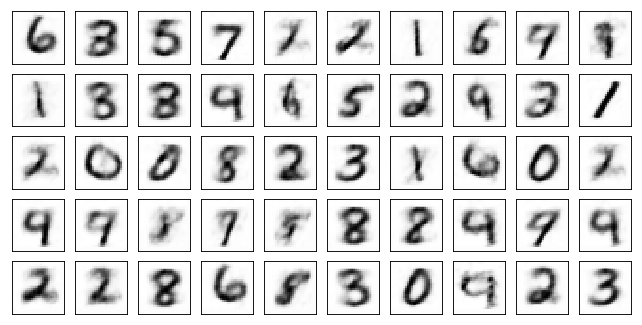

Test losses: VAE2: 0.1560/7.0805


In [73]:
for epoch in range(1, 31):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, epoch, test_log)